Button(button_style='success', description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Clic…

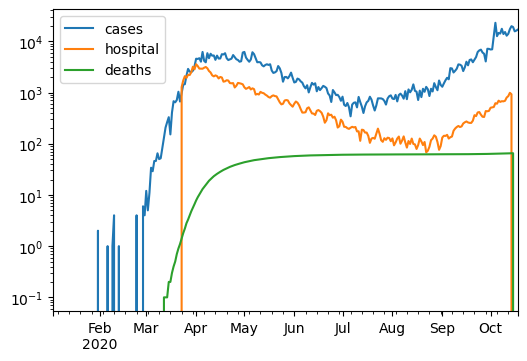

Output()

Dropdown(description='View: ', options=('cases', 'hospital', 'deaths'), value='cases')

Output()

SelectMultiple(description='Sex', index=(0, 1), options=('males', 'females', 'total'), rows=3, value=('males',…

Output()

SelectionSlider(continuous_update=False, description='Grade:', options=('nice', 'ok', 'bad'), value='nice')

Checkbox(value=False, description='That is all', indent=False)

In [ ]:
from IPython.display import clear_output
import ipywidgets as wdg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from uk_covid19 import Cov19API

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

jsondata={}

Filters = [  
    'areaType=nation',
    'areaName=England'
]

Structure = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "Cases": "newCasesByPublishDate",
    "cumCasesByPublishDate": "cumCasesByPublishDate",
    "newDeaths28DaysByDeathDate": "newDeaths28DaysByDeathDate",
    "deaths": "cumDeaths28DaysByDeathDate",
    "hospital": "newAdmissions"
}  #define a structure


with open("timeseries.json", "rt") as INFILE:
    data=json.load(INFILE) #读取数据  read data

datalist = data['data']

dates = [dictionary['date'] for dictionary in datalist]
dates.sort()

def parse_date(datestring):
    return pd.to_datetime(datestring, format="%Y-%m-%d")

startdate = parse_date(dates[0])
enddate = parse_date(dates[-1])#define the start and end time

def wrangle_data(data): #wrangle data
    
    index = pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'hospital', 'deaths'])

    for entry in datalist:
        date= parse_date(entry['date'])
        for column in ['cases','hospital','deaths']:
            if pd.isna(timeseriesdf.loc[date,column]):#loc Extracts the specified data
                value = float(entry[column]) if entry[column]!=None else 0.0
                timeseriesdf.loc[date,column] = value
    return timeseriesdf

timeseriesdf=wrangle_data(jsondata) #timeseriesdf is the dataframe for plotting

def access_api():

    api = Cov19API(filters=Filters, structure=Structure)
    data = api.get_json()
    #sends the request to the API and retrieves the response
    
    with open("data.json","wt") as OUTF:
        json.dump(data, OUTF) # save data as json format
    
    api_timestamp = api.last_update # data release time


def api_button_callback(button):

    apidata=access_api()

    global timeseriesdf ##define global variables
    timeseriesdf=wrangle_data(apidata) #data callback

    refresh_graph() #refresh graph

    apibutton.icon="check"
    apibutton.disabled=True


           
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='success',# four values 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' 
)



apibutton.on_click(api_button_callback)#call assess api by api_button_callback

#display the buttons
display(apibutton)




timeseriesdf.fillna(0.0, inplace=True)
timeseriesdf.plot(logy=True)
timeseriesdf.to_pickle("timeseriesdf.pkl")
timeseriesdf = pd.read_pickle("timeseriesdf.pkl")


scale=wdg.RadioButtons( # Set the option box
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)


series=wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)


controls=wdg.HBox([scale, series])



def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() #update graph
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

# stack series and scale on top of each other
ctrls=wdg.VBox([series, scale])
# put the graph and the controls side by side
form=wdg.HBox([graph, ctrls])


# Now form contains the entire interface
display(form)

with open("agedistribution.json","rt") as INFILE:
    data1=json.load(INFILE)
    
datadic=data1['data'][0]
females=datadic['females']
males=datadic['males']
ageranges=[x['age'] for x in males]

def min_age(agerange):
    agerange=agerange.replace('+','')
    start=agerange.split('_')[0]
    return int(start)

ageranges.sort(key=min_age)
age_df=pd.DataFrame(index=ageranges, columns=['males','females','total']) # define DataFrame

for entry in males: 
    ageband=entry['age'] 
    age_df.loc[ageband, 'males']=entry['value']
    
for entry in females:
    ageband=entry['age']
    age_df.loc[ageband, 'females']=entry['value']
    #loc Extracts the specified data

age_df['total']=age_df['males']+age_df['females']




agecols=wdg.SelectMultiple(
    options=['males', 'females', 'total'],
    value=['males', 'females'], 
    rows=3,
    description='Sex',
    disabled=False
)

age_df.to_pickle("agedf.pkl")
age_df=pd.read_pickle("agedf.pkl")



def plot_random_walk(walk):
    timeseriesdf[walk].plot()
    plt.show() #call the data of timeserisedf to draw
    graph():#force pattern to refresh by changing called data
    
    current=whichwalk.value
    if current==whichwalk.options[0]:
        other=whichwalk.options[1]
    else:
        other=whichwalk.options[0]
    whichwalk.value=other
    whichwalk.value=current                    
    
graph=wdg.interactive_output(plot_random_walk, {'walk': whichwalk})
whichwalk=wdg.Dropdown(
    options=['cases', 'hospital', 'deaths'],
    value='cases',
    description='View: ',
    disabled=False,
)

def refresh_
    
display(whichwalk, graph)

def age_graph(graphcolumns):
   
    ncols=len(graphcolumns)
    if ncols>0:
        age_df.plot(kind='bar', y=list(graphcolumns)) 
        plt.show() 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
    
output=wdg.interactive_output(age_graph, {'graphcolumns': agecols})# display graph

display(agecols, output) #display button



checkButton = wdg.Checkbox(
    value=False,
    description='That is all',
    disabled=False,
    indent=False
)

Grade=wdg.SelectionSlider(
    options=['nice', 'ok', 'bad'],
    value='nice',
    description='Grade:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
# I failed to add the slider to the shape
display(Grade)
display(checkButton)